In [2]:
import os
os.chdir("drive/MyDrive/fyp/src")

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from data import PolygonSentenceReader, Polygon, EOS_TOKEN
from modules import NLLLoss, ELBOLoss, MLP
from neural_process.models.np import CNP, LNP
from neural_process.models.attnnp import AttnCNP, AttnLNP
from transformer.models import TransformerDecoder
from utils import plot_polygon

import datetime
from functools import partial
from math import fabs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn
from torch.distributions.kl import kl_divergence

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Tf params
x_dim = 1
y_dim = 1
r_dim = 128

# NP params
BATCH_SIZE = 128
MAX_CONTEXT_POINTS = 15
MIN_SIDES = 3
MAX_SIDES = 8
x_size = 5 + 4 * 12
y_size = x_size
torch.manual_seed(0)

CNPDecoder = partial(
    MLP,
    n_hidden_layers=6,
    hidden_size=320,
    dropout=0.2,
    is_res=True,
)
CNPEncoder = partial(
    MLP,
    n_hidden_layers=8,
    hidden_size=320,
    dropout=0.2,
    is_res=True,
)

ANPEncoder = partial(
    MLP,
    n_hidden_layers=2,
    hidden_size=224,
    dropout=0.2,
    is_res=True,
)

ANPDecoder = partial(
    MLP,
    n_hidden_layers=3,
    hidden_size=224,
    dropout=0.2,
    is_res=False,
)

ANPLatentEncoder = partial(
    MLP,
    n_hidden_layers=4,
    hidden_size=224,
    dropout=0.2,
    is_res=True,
)

# CNP
cnp_model = CNP(x_dim=x_size, y_dim=y_size, r_dim=320, Decoder=CNPDecoder, Encoder=CNPEncoder)
cnp_model.load_state_dict(torch.load("../models/polygon/np/transformation_task/CNP.pt"))
cnp_model.eval()
cnp_model.to(device)
total_params = sum(p.numel() for p in cnp_model.parameters())
print(f"CNP Total parameters: {total_params:,}")

# NP
np_model = LNP(x_dim=x_size, y_dim=y_size, r_dim=256, n_z_train=10, n_z_test=10)
np_model.load_state_dict(torch.load("../models/polygon/np/transformation_task/LNP.pt"))
np_model.eval()
np_model.to(device)
total_params = sum(p.numel() for p in np_model.parameters())
print(f"NP Total parameters: {total_params:,}")

# ANP
anp_model = AttnLNP(
    x_dim=x_size,
    y_dim=y_size,
    r_dim=224,
    attention_type="multihead",
    n_z_train=10,
    n_z_test=10,
    Encoder=ANPEncoder,
    LatentEncoder=ANPLatentEncoder,
    Decoder=ANPDecoder,
)
anp_model.load_state_dict(torch.load("../models/polygon/np/transformation_task/AttnLNP.pt"))
anp_model.eval()
anp_model.to(device)
total_params = sum(p.numel() for p in anp_model.parameters())
print(f"ANP Total parameters: {total_params:,}")

# Reconstruct the Transformer model and load the trained checkpoint
tf_model = TransformerDecoder(x_dim, y_dim, r_dim=r_dim, decoder_layers=8, decoder_heads=8)
checkpoint_path = f"../final_tf_model_1586561_params.pt"
checkpoint = torch.load(checkpoint_path, map_location=device)
tf_model.load_state_dict(checkpoint['model_state_dict'])
total_params = sum(p.numel() for p in tf_model.parameters())
print(f"TF Total parameters: {total_params:,}")
tf_model.eval()
tf_model.to(device)

cuda
CNP Total parameters: 1,532,266
NP Total parameters: 1,524,586
ANP Total parameters: 1,548,394


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


TF Total parameters: 1,586,561


TransformerDecoder(
  (project_r): Sequential(
    (0): Linear(in_features=1, out_features=128, bias=True)
    (1): ReLU()
  )
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-7): 8 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (fc_out): Linear(in_features=128, out_features=1, bias=True)
)

In [14]:
def evaluate_neural_process_transformation_on_batch(
    model, ctx_x, ctx_y, tgt_x, tgt_y,
    true_trans, max_seq_len, device, plot=False
):
    """
    Few-shot masked completion with a Neural Process.
    """
    model.eval()
    with torch.no_grad():
        p_y_dist, z, q_zc, q_zct = model(
            ctx_x, ctx_y, tgt_x, None
        )
        mean_z = p_y_dist.mean.mean(dim=0)
        pred_y = mean_z[:, -1, :]
        pred_y = pred_y.detach().cpu()

    B = pred_y.shape[0]
    all_errs = []
    per_example_mae = []
    per_example_sum_err = []

    for i in range(B):
        true = true_trans[i][0].to_tokenised()

        # per-token absolute errors
        errs = [abs(p - t) for p, t in zip(pred_y[i], true)]
        all_errs.extend(errs)

        # per-example MAE
        per_example_mae.append(sum(errs) / len(errs))

        # per-example sum error
        per_example_sum_err.append(abs(sum(pred_y[i]) - sum(true)))

    if len(all_errs) == 0:
        return 0.0, 0.0, 0.0

    avg_abs_err = sum(all_errs) / len(all_errs)
    avg_angle_mae = sum(per_example_mae) / len(per_example_mae)
    avg_angle_sum_err= sum(per_example_sum_err) / len(per_example_sum_err)

    # Plot last predicted transformed polygon
    if plot:
        predicted_polygon = Polygon.from_tokenised(pred_y[-1].tolist()[:len(true)], true[0])
        plot_polygon(predicted_polygon.vertices, title=f"Predicted Transformed Polygon {model.__class__.__name__} - {avg_abs_err:.2f}")

    return (
        avg_abs_err,
        avg_angle_mae,
        avg_angle_sum_err
    )

def evaluate_transformer_transformation_on_batch(
    model, ctx_x, ctx_y, tgt_x, tgt_y,
    true_trans, max_seq_len, device, plot=False
):
    """
    Few-shot masked completion with a Transformer.
    """
    B, C, _ = ctx_x.shape

    all_errs = []
    per_example_mae = []
    per_example_sum_err = []

    model.eval()
    with torch.no_grad():
        for i in range(B):
            # Build prompt
            prompt = []
            for j in range(C):
                toks = ctx_x[i,j].tolist()
                while toks and toks[-1]==0.0: toks.pop()
                prompt += toks
                toks = ctx_y[i,j].tolist()
                while toks and toks[-1]==0.0: toks.pop()
                prompt += toks

            partial = tgt_x[i,-1].tolist()
            while partial and partial[-1]==0.0: partial.pop()
            prompt += partial
            L_tgt = len(partial)

            # Autoregressive loop
            generated = prompt.copy()
            for _ in range(L_tgt):
                if len(generated) > max_seq_len:
                    generated = generated[-max_seq_len:]
                inp = (
                    torch.tensor(generated, device=device)
                         .unsqueeze(1).unsqueeze(-1)
                )  # [seq_len, 1, 1]
                logits = model(inp)    # → same shape
                nxt = logits[-1, 0, 0].item()
                generated.append(nxt)

            # Extract the newly generated segment
            pred_seq = generated[-L_tgt:] # length tgt_y_len

            true = true_trans[i][0].to_tokenised()

            errs = [abs(p - t) for p, t in zip(pred_seq, true)]
            all_errs.extend(errs)
            per_example_mae.append(sum(errs) / len(errs))
            per_example_sum_err.append(abs(sum(pred_seq) - sum(true)))

    if len(all_errs) == 0:
        return 0.0, 0.0, 0.0

    avg_abs_err = sum(all_errs) / len(all_errs)
    avg_masked_mae = sum(per_example_mae) / len(per_example_mae)
    avg_masked_sum_err = sum(per_example_sum_err) / len(per_example_sum_err)

    if plot:
        predicted_polygon = Polygon.from_tokenised(pred_seq, true[0])
        plot_polygon(predicted_polygon.vertices, title=f"Predicted Transformed Polygon {model.__class__.__name__} - {avg_abs_err:.2f}")

    return (
        avg_abs_err,
        avg_masked_mae,
        avg_masked_sum_err,
    )

In [15]:
def compare_models_shared_data(reader, cnp_model, np_model, anp_model, tf_model, tf_max_seq_len, context_sizes, runs_per_size, trans_cfg, ood, device, plot=False):
    """
    Compare NP and Transformer on same sampled tasks.
    """
    results = {
        'CNP': {},
        'LNP': {},
        'ANP': {},
        'TF': {},
    }

    results_std = {
        'CNP': {},
        'LNP': {},
        'ANP': {},
        'TF': {},
    }

    np_model.to(device).eval()
    tf_model.to(device).eval()

    for c in context_sizes:
        errs_cnp, maes_cnp, sums_cnp = [], [], []
        errs_np, maes_np, sums_np = [], [], []
        errs_anp, maes_anp, sums_anp = [], [], []
        errs_tf, maes_tf, sums_tf = [], [], []

        for _ in range(runs_per_size):
            # Generate a single batch of tasks (shared data)
            (ctx_x, ctx_y, tgt_x, tgt_y, _,
             _, true_trans, max_seq_len, _, _) = reader.generate_polygon_batch_few_shot_transformation_task(
                num_context=c,
                transformation_type=trans_cfg['type'],
                next_transformation_type=trans_cfg.get("next_type", None),
                eval=ood,
            )

            ctx_x, ctx_y = ctx_x.to(device), ctx_y.to(device)
            tgt_x, tgt_y = tgt_x.to(device), tgt_y.to(device)

            # -- Conditional Neural Process evaluation --
            avg_cnp, mae_cnp, sum_cnp = evaluate_neural_process_transformation_on_batch(
                cnp_model, ctx_x, ctx_y, tgt_x, tgt_y, true_trans, max_seq_len, device, plot
            )
            errs_cnp.append(avg_cnp); maes_cnp.append(mae_cnp); sums_cnp.append(sum_cnp)

            # -- Latent Neural Process evaluation --
            avg_np, mae_np, sum_np = evaluate_neural_process_transformation_on_batch(
                np_model, ctx_x, ctx_y, tgt_x, tgt_y, true_trans, max_seq_len, device, plot
            )
            errs_np.append(avg_np); maes_np.append(mae_np); sums_np.append(sum_np)

            # -- Attentive Neural Process evaluation --
            avg_anp, mae_anp, sum_anp = evaluate_neural_process_transformation_on_batch(
                anp_model, ctx_x, ctx_y, tgt_x, tgt_y, true_trans, max_seq_len, device, plot
            )
            errs_anp.append(avg_anp); maes_anp.append(mae_anp); sums_anp.append(sum_anp)

            # -- Transformer evaluation --
            avg_tf, mae_tf, sum_tf = evaluate_transformer_transformation_on_batch(
                tf_model, ctx_x, ctx_y, tgt_x, tgt_y, true_trans, tf_max_seq_len, device, plot
            )
            errs_tf.append(avg_tf); maes_tf.append(mae_tf); sums_tf.append(sum_tf)

        results['CNP'][c] = {
            'abs_err': np.mean(errs_cnp),
            'masked_mae': np.mean(maes_cnp),
            'sum_err': np.mean(sums_cnp),
        }
        results['LNP'][c] = {
            'abs_err': np.mean(errs_np),
            'masked_mae': np.mean(maes_np),
            'sum_err': np.mean(sums_np),
        }
        results['ANP'][c] = {
            'abs_err': np.mean(errs_anp),
            'masked_mae': np.mean(maes_anp),
            'sum_err': np.mean(sums_anp),
        }
        results['TF'][c] = {
            'abs_err': np.mean(errs_tf),
            'masked_mae': np.mean(maes_tf),
            'sum_err': np.mean(sums_tf),
        }

        results_std['CNP'][c] = {
            'abs_err': np.mean(errs_cnp),
            'masked_mae': np.mean(maes_cnp),
            'sum_err': np.mean(sums_cnp),
        }
        results_std['LNP'][c] = {
            'abs_err': np.std(errs_np),
            'masked_mae': np.std(maes_np),
            'sum_err': np.std(sums_np),
        }
        results_std['ANP'][c] = {
            'abs_err': np.std(errs_anp),
            'masked_mae': np.std(maes_anp),
            'sum_err': np.std(sums_anp),
        }
        results_std['TF'][c] = {
            'abs_err': np.std(errs_tf),
            'masked_mae': np.std(maes_tf),
            'sum_err': np.std(sums_tf),
        }

    return results, results_std

    # plot_configs = [
    #     # ('abs_err',    'Average Absolute Error'),
    #     ('masked_mae', 'Masked MAE'),
    #     # ('sum_err',    'Masked Sum Error'),
    # ]
    # model_plotting = [
    #     ('CNP', '-^'),
    #     ('LNP',  '-o'),
    #     ('ANP', '-x'),
    #     ('TF',  '-s'),
    # ]

    # # Plot results
    # for metric, ylabel in plot_configs:
    #     plt.figure(figsize=(7,4))
    #     for name, marker in model_plotting:
    #         ys = [results[name][c][metric] for c in context_sizes]
    #         plt.plot(context_sizes, ys, marker, label=name)
    #     plt.xlabel("Number of Context Points")
    #     plt.ylabel(ylabel)
    #     plt.xticks(context_sizes)
    #     plt.legend()
    #     plt.title(f"Transformation {ylabel} vs Context Size")
    #     plt.grid(True)
    #     plt.tight_layout()
    #     plt.show()


In [8]:
def plot_polygon_on_ax(ax, vertices, title=None):
    """
    Draws a single convex polygon onto the given Axes.
    """
    # Close the polygon
    xs = [v[0] for v in vertices] + [vertices[0][0]]
    ys = [v[1] for v in vertices] + [vertices[0][1]]

    ax.plot(xs, ys, marker='o', linestyle='-')
    ax.fill(xs, ys, alpha=0.2)
    # ax.set_aspect('equal', 'box')
    if title:
        ax.set_title(title, fontsize=8)

In [15]:
def visualise_polygon_evaluation(pred_target, true_target, true_transformed_target):

    true_polygon_tokenised = true_polygon.to_tokenised()
    true_transformed_polygon_tokenised = true_transformed_polygon.to_tokenised()
    predicted_polygon = Polygon.from_tokenised(pred_target_avg.tolist()[:len(true_polygon_tokenised)], true_polygon_tokenised[0])

    print("Original Polygon: ", true_polygon)
    print("Gold Label Transformed Polygon: ", true_transformed_polygon)
    print("Predicted Transformed Polygon: ", predicted_polygon)

    plot_polygon(true_polygon.vertices, title="Original Polygon")
    plot_polygon(true_transformed_polygon.vertices, title="Gold Label Transformed Polygon")
    plot_polygon(predicted_polygon.vertices, title="Predicted Transformed Polygon")


# Polygon Sides 9-12


############################################################
Testing transformation: {'type': 'rotation'}
############################################################ 

→ 9-sided polygons
→ 10-sided polygons
→ 11-sided polygons
→ 12-sided polygons


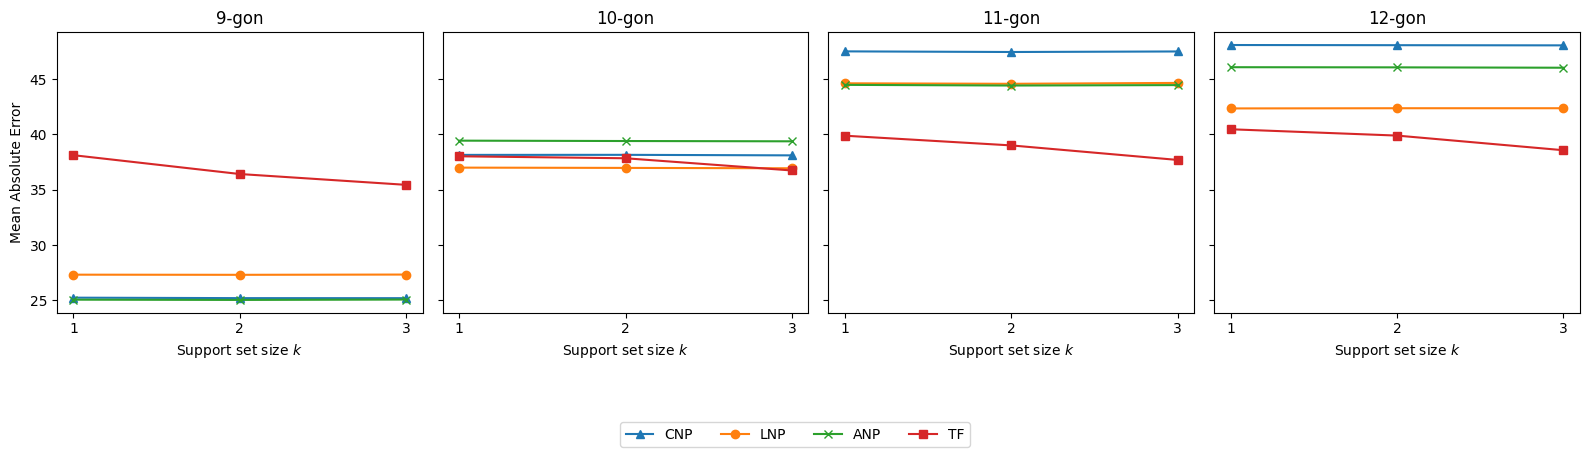


############################################################
Testing transformation: {'type': 'scaling'}
############################################################ 

→ 9-sided polygons
→ 10-sided polygons
→ 11-sided polygons
→ 12-sided polygons


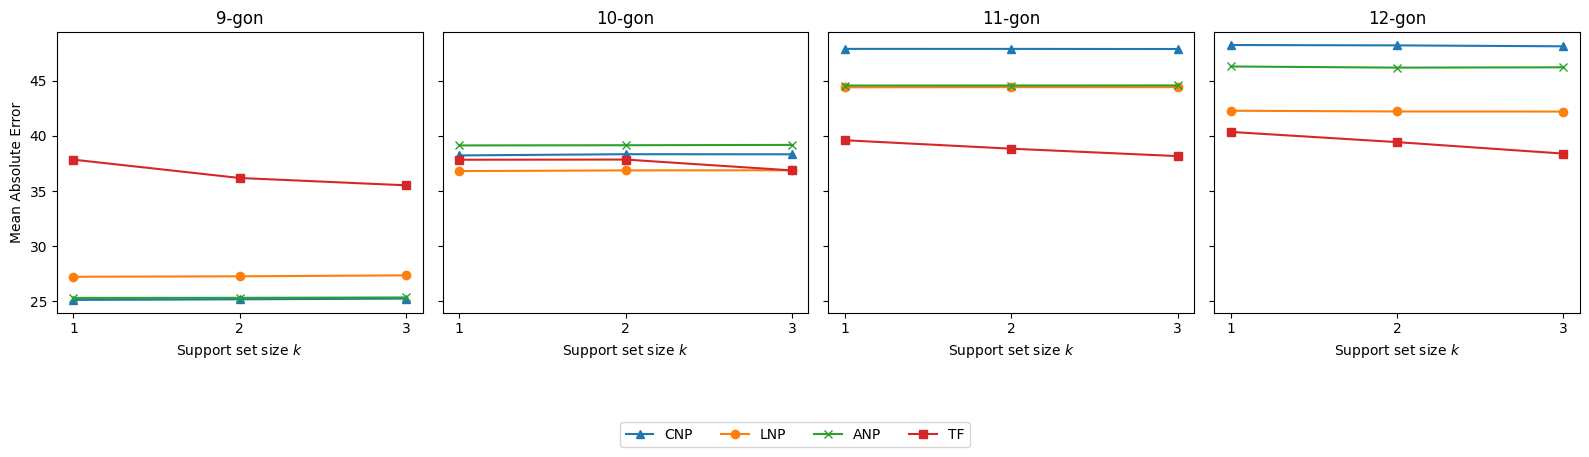


############################################################
Testing transformation: {'type': 'translation'}
############################################################ 

→ 9-sided polygons
→ 10-sided polygons
→ 11-sided polygons
→ 12-sided polygons


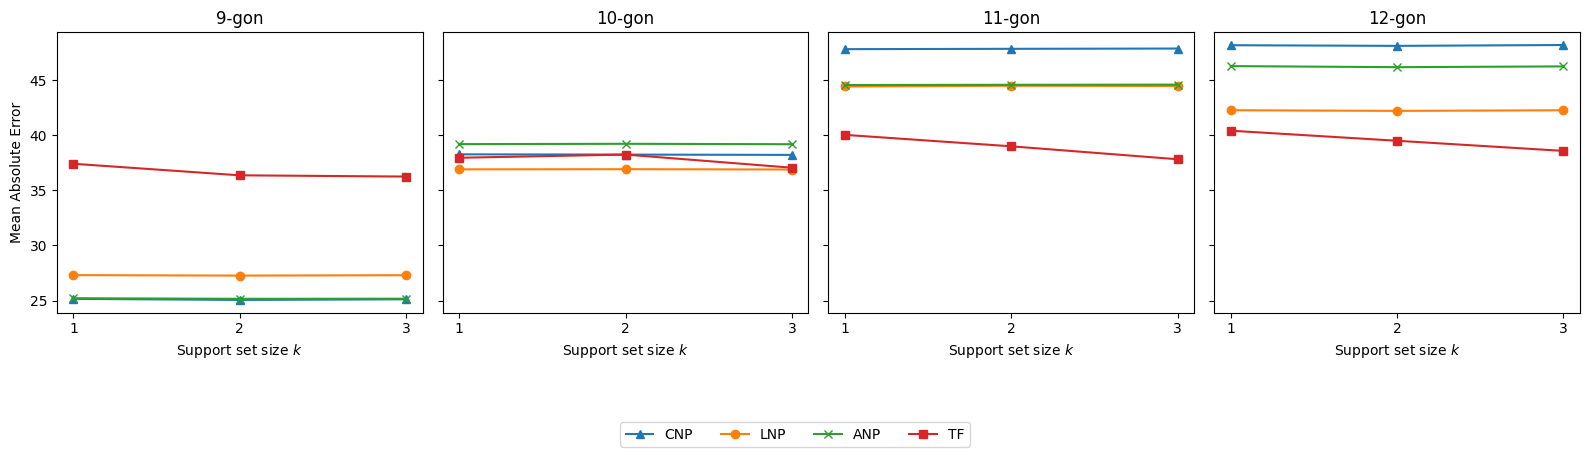


############################################################
Testing transformation: {'type': None}
############################################################ 

→ 9-sided polygons
→ 10-sided polygons
→ 11-sided polygons
→ 12-sided polygons


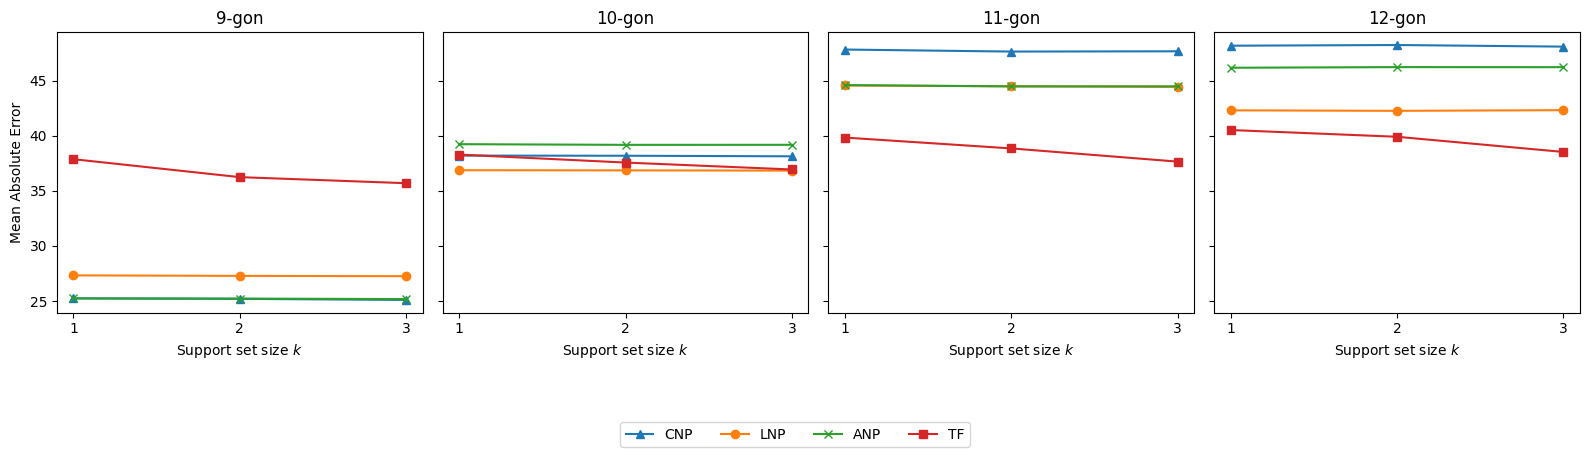

Saved consolidated results to ../figures/all_polygon_sides_results.csv


In [16]:
sides = range(9, 13)
context_sizes = list(range(1, 4))
runs_per_size = 10
tf_max_seq_len = 512

transformation_configs = [
    {"type": "rotation"},
    {"type": "scaling"},
    {"type": "translation"},
    {"type": None}, # random sample transformations
]

all_rows = []

for trans_cfg in transformation_configs:
    print("\n" + "#"*60)
    print("Testing transformation:", trans_cfg)
    print("#"*60, "\n")

    results = {s : {} for s in sides}

    for s in sides:
        print(f"→ {s}-sided polygons")
        # make a reader that only generates s-sided polygons, with deterministic masks
        polygon_reader_eval = PolygonSentenceReader(
            batch_size=128,
            max_num_context=MAX_CONTEXT_POINTS,
            max_seq_len=x_size,
            min_num_sides=s,
            max_num_sides=s,
            testing=True,
        )

        masked_mae, masked_mae_std = compare_models_shared_data(
            reader=polygon_reader_eval,
            cnp_model=cnp_model,
            np_model=np_model,
            anp_model=anp_model,
            tf_model=tf_model,
            tf_max_seq_len=tf_max_seq_len,
            context_sizes=context_sizes,
            runs_per_size=runs_per_size,
            trans_cfg=trans_cfg,
            ood=False,
            device=device
        )

        results[s]["masked_mae"], results[s]["masked_mae_std"] = masked_mae, masked_mae_std

        for model_name in ['CNP','LNP','ANP','TF']:
            for k in context_sizes:
                m  = results[s]['masked_mae'][model_name][k]["masked_mae"]
                sd = results[s]['masked_mae_std'][ model_name][k]["masked_mae"]
                all_rows.append({
                    'transformation_type': trans_cfg['type'],
                    'side_count':  s,
                    'model':       model_name,
                    'k':           k,
                    'mae_mean':    m,
                    'mae_std':     sd
                })

    model_plotting = [
        ('CNP', '-^'),
        ('LNP',  '-o'),
        ('ANP', '-x'),
        ('TF',  '-s'),
    ]

    ncols = len(sides)
    fig, axes = plt.subplots(
        1, ncols,
        sharey=True,
        figsize=(4 * ncols, 4)
    )

    for ax, s in zip(axes, sides):
        for model_name, marker in model_plotting:
            ys   = [results[s]['masked_mae'][model_name][k]["masked_mae"] for k in context_sizes]
            yerr = [results[s]['masked_mae_std'][model_name][k]["masked_mae"] for k in context_sizes]
            ax.plot(
                context_sizes, ys,
                marker,
                label=model_name,
            )
        ax.set_title(f"{s}-gon")
        ax.set_xlabel("Support set size $k$")
        ax.set_xticks(context_sizes)

    axes[0].set_ylabel("Mean Absolute Error")

    # one legend for all
    fig.legend(
        [m for m,_ in model_plotting],
        loc='upper center',
        ncol=len(model_plotting),
        bbox_to_anchor=(0.5, -0.05),
    )

    fig.tight_layout(rect=[0,0.05,1,1])
    if trans_cfg['type'] is None:
        fig.savefig(f"../figures/polygon_sides_{trans_cfg['type']}.pdf",
                    bbox_inches='tight',)
    else:
        fig.savefig(f"../figures/polygon_sides_{trans_cfg['type']}.pdf")
    plt.show()

df = pd.DataFrame(all_rows)
df.to_csv('../figures/all_polygon_sides_results.csv', index=False)
print(f"Saved consolidated results to ../figures/all_polygon_sides_results.csv")

# Unseen Transformations


############################################################
Testing transformation: {'type': 'rotation'}
############################################################ 

→ 3-sided polygons
→ 4-sided polygons
→ 5-sided polygons
→ 6-sided polygons
→ 7-sided polygons
→ 8-sided polygons


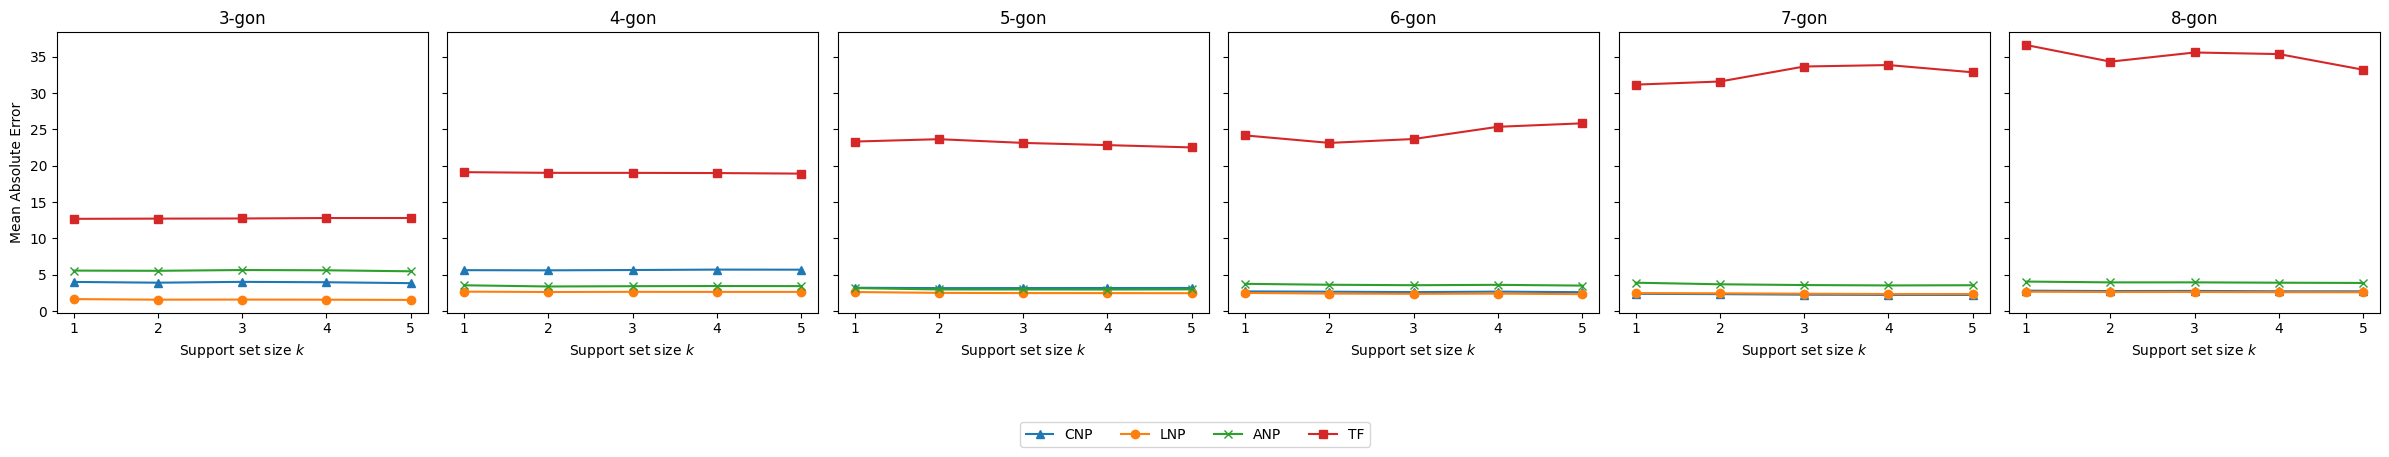


############################################################
Testing transformation: {'type': 'scaling'}
############################################################ 

→ 3-sided polygons
→ 4-sided polygons
→ 5-sided polygons
→ 6-sided polygons
→ 7-sided polygons
→ 8-sided polygons


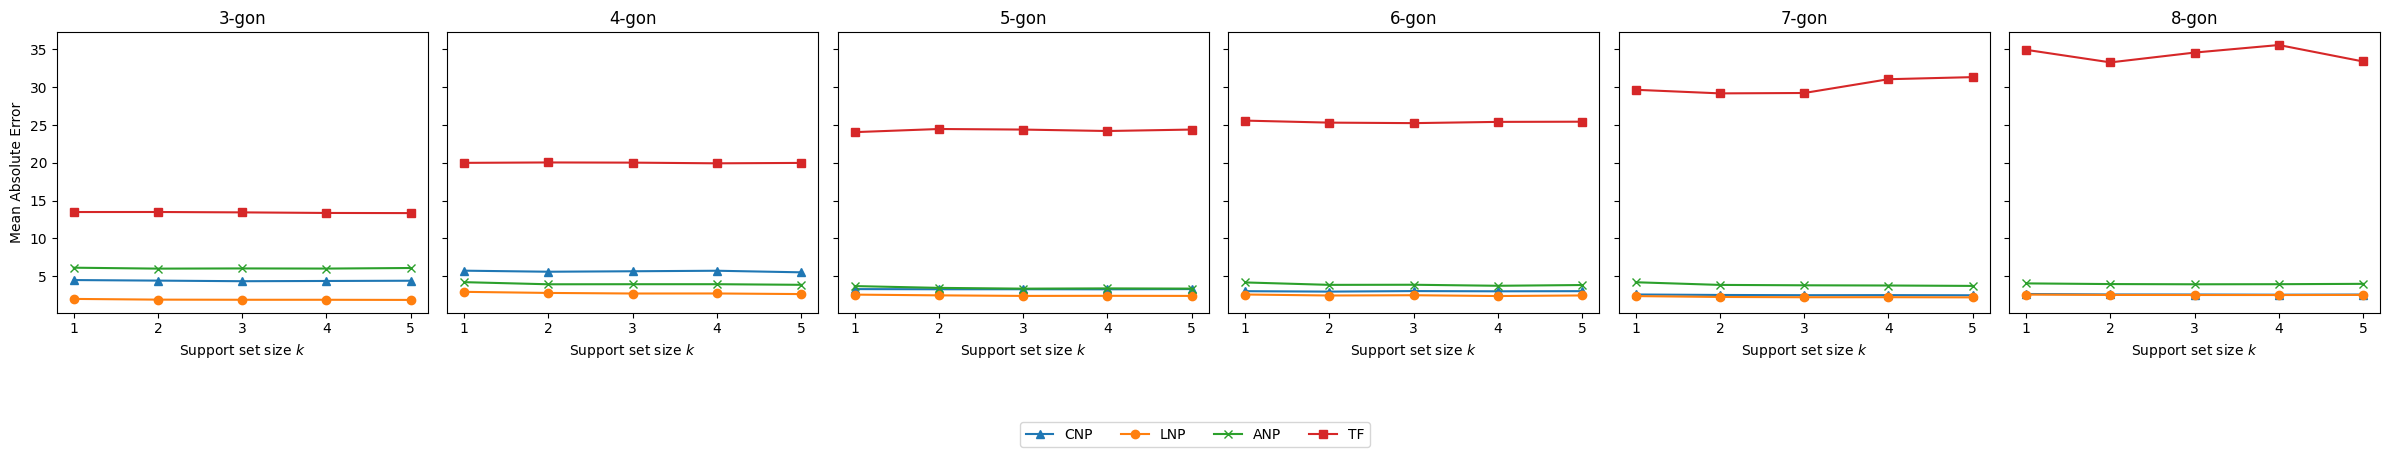


############################################################
Testing transformation: {'type': 'translation'}
############################################################ 

→ 3-sided polygons
→ 4-sided polygons
→ 5-sided polygons
→ 6-sided polygons


In [ ]:
sides = range(3, 9)
context_sizes = list(range(1, 6))
runs_per_size = 10
tf_max_seq_len = 512

transformation_configs = [
    {"type": "rotation"},
    {"type": "scaling"},
    {"type": "translation"},
    {"type": None}, # random sample transformations
]

all_rows = []

for trans_cfg in transformation_configs:
    print("\n" + "#"*60)
    print("Testing transformation:", trans_cfg)
    print("#"*60, "\n")

    results = {s : {} for s in sides}

    for s in sides:
        print(f"→ {s}-sided polygons")
        # make a reader that only generates s-sided polygons, with deterministic masks
        polygon_reader_eval = PolygonSentenceReader(
            batch_size=128,
            max_num_context=MAX_CONTEXT_POINTS,
            max_seq_len=x_size,
            min_num_sides=s,
            max_num_sides=s,
            testing=True,
        )

        masked_mae, masked_mae_std = compare_models_shared_data(
            reader=polygon_reader_eval,
            cnp_model=cnp_model,
            np_model=np_model,
            anp_model=anp_model,
            tf_model=tf_model,
            tf_max_seq_len=tf_max_seq_len,
            context_sizes=context_sizes,
            runs_per_size=runs_per_size,
            trans_cfg=trans_cfg,
            ood=True,
            device=device
        )

        results[s]["masked_mae"], results[s]["masked_mae_std"] = masked_mae, masked_mae_std

        for model_name in ['CNP','LNP','ANP','TF']:
            for k in context_sizes:
                m  = results[s]['masked_mae'][model_name][k]["masked_mae"]
                sd = results[s]['masked_mae_std'][ model_name][k]["masked_mae"]
                all_rows.append({
                    'transformation_type': trans_cfg['type'],
                    'side_count':  s,
                    'model':       model_name,
                    'k':           k,
                    'mae_mean':    m,
                    'mae_std':     sd
                })

    model_plotting = [
        ('CNP', '-^'),
        ('LNP',  '-o'),
        ('ANP', '-x'),
        ('TF',  '-s'),
    ]

    ncols = len(sides)
    fig, axes = plt.subplots(
        1, ncols,
        sharey=True,
        figsize=(4 * ncols, 4)
    )

    for ax, s in zip(axes, sides):
        for model_name, marker in model_plotting:
            ys   = [results[s]['masked_mae'][model_name][k]["masked_mae"] for k in context_sizes]
            yerr = [results[s]['masked_mae_std'][model_name][k]["masked_mae"] for k in context_sizes]
            ax.plot(
                context_sizes, ys,
                marker,
                label=model_name,
            )
        ax.set_title(f"{s}-gon")
        ax.set_xlabel("Support set size $k$")
        ax.set_xticks(context_sizes)

    axes[0].set_ylabel("Mean Absolute Error")

    # one legend for all
    fig.legend(
        [m for m,_ in model_plotting],
        loc='upper center',
        ncol=len(model_plotting),
        bbox_to_anchor=(0.5, -0.05),
    )

    fig.tight_layout(rect=[0,0.05,1,1])
    if trans_cfg['type'] is None:
        fig.savefig(f"../figures/ood_transformation_{trans_cfg['type']}.pdf",
                    bbox_inches='tight',)
    else:
        fig.savefig(f"../figures/ood_transformation_{trans_cfg['type']}.pdf")
    plt.show()

df = pd.DataFrame(all_rows)
df.to_csv('../figures/ood_param_transformation_results.csv', index=False)
print(f"Saved consolidated results to ../figures/ood_param_transformations_results.csv")

# Shifted Circumference


############################################################
Testing transformation: {'type': 'rotation'}
############################################################ 

→ 3-sided polygons
→ 4-sided polygons
→ 5-sided polygons
→ 6-sided polygons
→ 7-sided polygons
→ 8-sided polygons


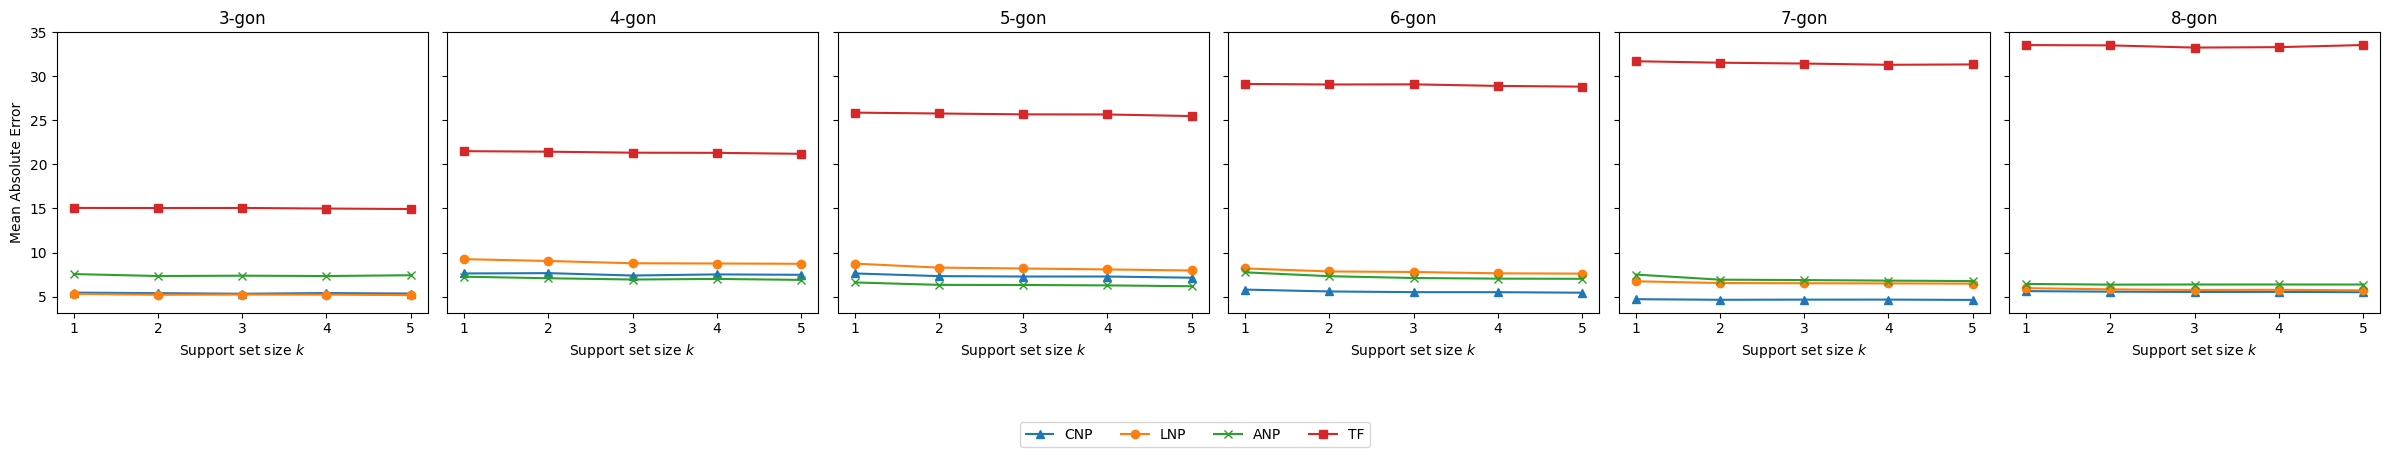


############################################################
Testing transformation: {'type': 'scaling'}
############################################################ 

→ 3-sided polygons
→ 4-sided polygons
→ 5-sided polygons
→ 6-sided polygons
→ 7-sided polygons
→ 8-sided polygons


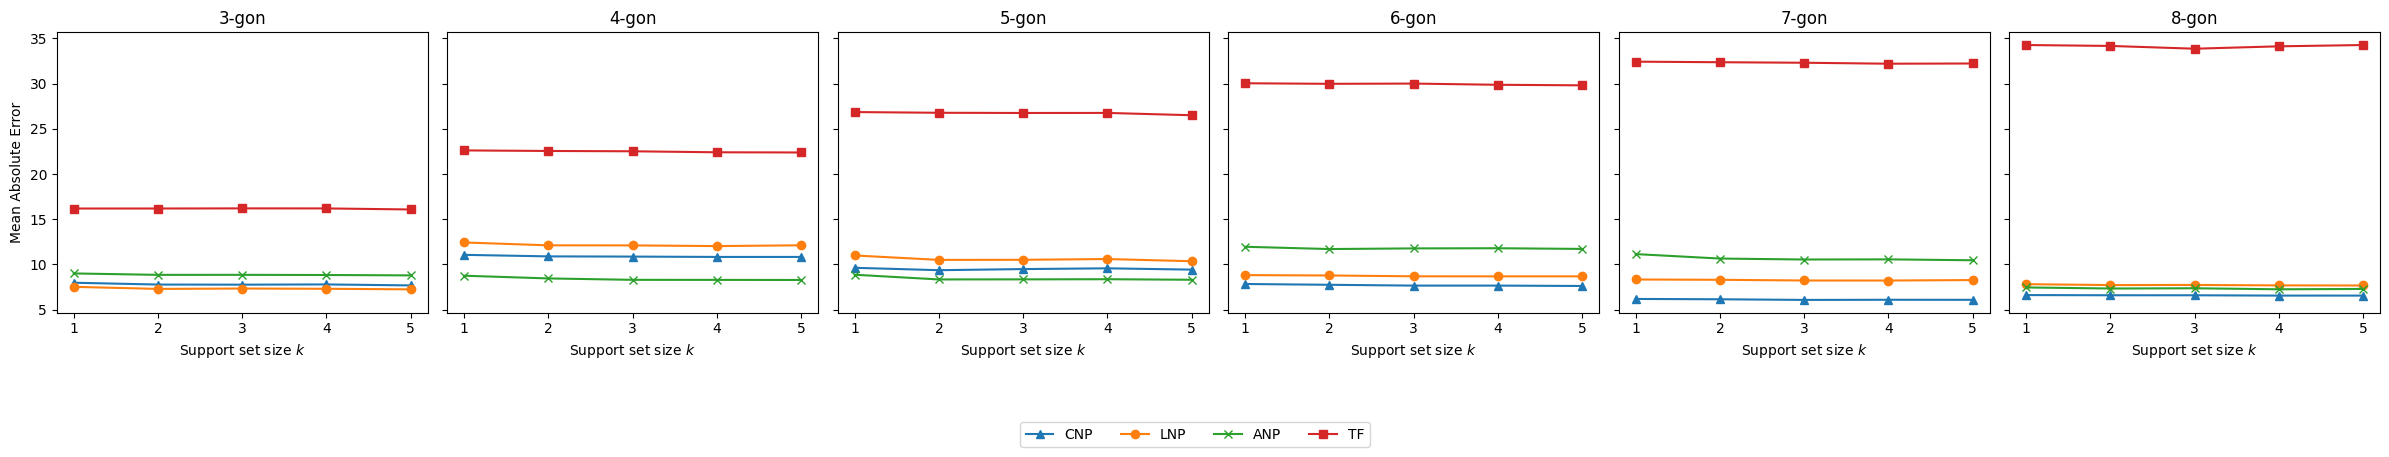


############################################################
Testing transformation: {'type': 'translation'}
############################################################ 

→ 3-sided polygons
→ 4-sided polygons
→ 5-sided polygons
→ 6-sided polygons
→ 7-sided polygons
→ 8-sided polygons


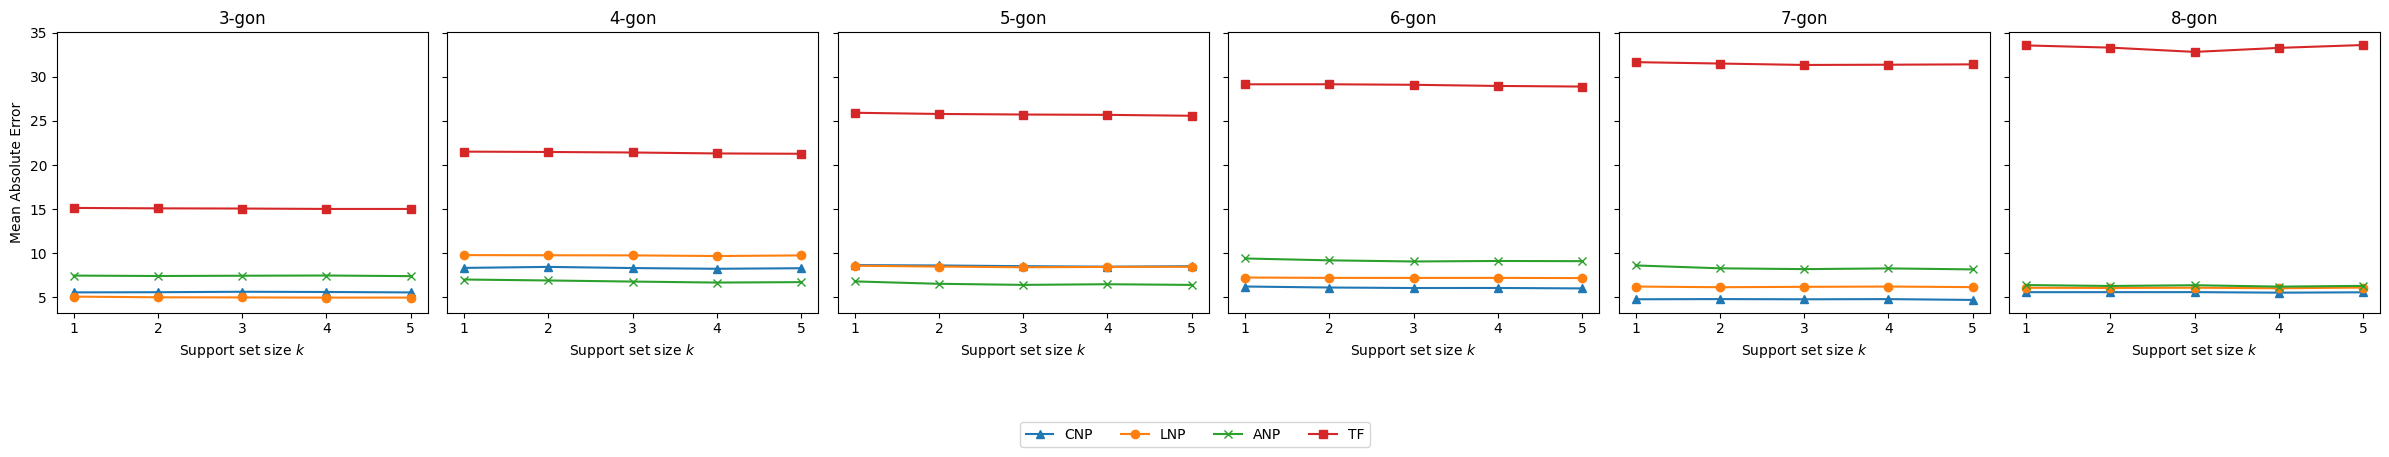


############################################################
Testing transformation: {'type': None}
############################################################ 

→ 3-sided polygons
→ 4-sided polygons
→ 5-sided polygons
→ 6-sided polygons
→ 7-sided polygons
→ 8-sided polygons


In [ ]:
sides = range(3, 9)
context_sizes = list(range(1, 6))
runs_per_size = 10
tf_max_seq_len = 512

transformation_configs = [
    {"type": "rotation"},
    {"type": "scaling"},
    {"type": "translation"},
    {"type": None}, # random sample transformations
]

all_rows = []

for trans_cfg in transformation_configs:
    print("\n" + "#"*60)
    print("Testing transformation:", trans_cfg)
    print("#"*60, "\n")

    results = {s : {} for s in sides}

    for s in sides:
        print(f"→ {s}-sided polygons")
        # make a reader that only generates s-sided polygons, with deterministic masks
        polygon_reader_eval = PolygonSentenceReader(
            batch_size=128,
            max_num_context=MAX_CONTEXT_POINTS,
            max_seq_len=x_size,
            min_num_sides=s,
            max_num_sides=s,
            center=(12,12),
            radius=6,
            testing=True,
        )

        masked_mae, masked_mae_std = compare_models_shared_data(
            reader=polygon_reader_eval,
            cnp_model=cnp_model,
            np_model=np_model,
            anp_model=anp_model,
            tf_model=tf_model,
            tf_max_seq_len=tf_max_seq_len,
            context_sizes=context_sizes,
            runs_per_size=runs_per_size,
            trans_cfg=trans_cfg,
            ood=True,
            device=device
        )

        results[s]["masked_mae"], results[s]["masked_mae_std"] = masked_mae, masked_mae_std

        for model_name in ['CNP','LNP','ANP','TF']:
            for k in context_sizes:
                m  = results[s]['masked_mae'][model_name][k]["masked_mae"]
                sd = results[s]['masked_mae_std'][ model_name][k]["masked_mae"]
                all_rows.append({
                    'transformation_type': trans_cfg['type'],
                    'side_count':  s,
                    'model':       model_name,
                    'k':           k,
                    'mae_mean':    m,
                    'mae_std':     sd
                })

    model_plotting = [
        ('CNP', '-^'),
        ('LNP',  '-o'),
        ('ANP', '-x'),
        ('TF',  '-s'),
    ]

    ncols = len(sides)
    fig, axes = plt.subplots(
        1, ncols,
        sharey=True,
        figsize=(4 * ncols, 4)
    )

    for ax, s in zip(axes, sides):
        for model_name, marker in model_plotting:
            ys   = [results[s]['masked_mae'][model_name][k]["masked_mae"] for k in context_sizes]
            yerr = [results[s]['masked_mae_std'][model_name][k]["masked_mae"] for k in context_sizes]
            ax.plot(
                context_sizes, ys,
                marker,
                label=model_name,
            )
        ax.set_title(f"{s}-gon")
        ax.set_xlabel("Support set size $k$")
        ax.set_xticks(context_sizes)

    axes[0].set_ylabel("Mean Absolute Error")

    # one legend for all
    fig.legend(
        [m for m,_ in model_plotting],
        loc='upper center',
        ncol=len(model_plotting),
        bbox_to_anchor=(0.5, -0.05),
    )

    fig.tight_layout(rect=[0,0.05,1,1])
    if trans_cfg['type'] is None:
        fig.savefig(f"../figures/shifted_circumference_{trans_cfg['type']}.pdf",
                    bbox_inches='tight',)
    else:
        fig.savefig(f"../figures/shifted_circumference_{trans_cfg['type']}.pdf")
    plt.show()

df = pd.DataFrame(all_rows)
df.to_csv('../figures/shifted_circumference_transformation_results.csv', index=False)
print(f"Saved consolidated results to ../figures/shifted_circumference_transformations_results.csv")

# Composite Transformation

In [ ]:
sides = range(3, 9)
context_sizes = list(range(1, 6))
runs_per_size = 10
tf_max_seq_len = 512

transformation_configs = [
    {"type": None, "next_type": "random"}, # random sample transformations
]

all_rows = []

for trans_cfg in transformation_configs:
    print("\n" + "#"*60)
    print("Testing transformation:", trans_cfg)
    print("#"*60, "\n")

    results = {s : {} for s in sides}

    for s in sides:
        print(f"→ {s}-sided polygons")
        # make a reader that only generates s-sided polygons, with deterministic masks
        polygon_reader_eval = PolygonSentenceReader(
            batch_size=128,
            max_num_context=MAX_CONTEXT_POINTS,
            max_seq_len=x_size,
            min_num_sides=s,
            max_num_sides=s,
            testing=True,
        )

        masked_mae, masked_mae_std = compare_models_shared_data(
            reader=polygon_reader_eval,
            cnp_model=cnp_model,
            np_model=np_model,
            anp_model=anp_model,
            tf_model=tf_model,
            tf_max_seq_len=tf_max_seq_len,
            context_sizes=context_sizes,
            runs_per_size=runs_per_size,
            trans_cfg=trans_cfg,
            ood=False,
            device=device
        )

        results[s]["masked_mae"], results[s]["masked_mae_std"] = masked_mae, masked_mae_std

        for model_name in ['CNP','LNP','ANP','TF']:
            for k in context_sizes:
                m  = results[s]['masked_mae'][model_name][k]["masked_mae"]
                sd = results[s]['masked_mae_std'][ model_name][k]["masked_mae"]
                all_rows.append({
                    'transformation_type': trans_cfg['type'],
                    'side_count':  s,
                    'model':       model_name,
                    'k':           k,
                    'mae_mean':    m,
                    'mae_std':     sd
                })

    model_plotting = [
        ('CNP', '-^'),
        ('LNP',  '-o'),
        ('ANP', '-x'),
        ('TF',  '-s'),
    ]

    ncols = len(sides)
    fig, axes = plt.subplots(
        1, ncols,
        sharey=True,
        figsize=(4 * ncols, 4)
    )

    for ax, s in zip(axes, sides):
        for model_name, marker in model_plotting:
            ys   = [results[s]['masked_mae'][model_name][k]["masked_mae"] for k in context_sizes]
            yerr = [results[s]['masked_mae_std'][model_name][k]["masked_mae"] for k in context_sizes]
            ax.plot(
                context_sizes, ys,
                marker,
                label=model_name,
            )
        ax.set_title(f"{s}-gon")
        ax.set_xlabel("Support set size $k$")
        ax.set_xticks(context_sizes)

    axes[0].set_ylabel("Mean Absolute Error")

    # one legend for all
    fig.legend(
        [m for m,_ in model_plotting],
        loc='upper center',
        ncol=len(model_plotting),
        bbox_to_anchor=(0.5, -0.05),
    )

    fig.tight_layout(rect=[0,0.05,1,1])
    if trans_cfg['type'] is None:
        fig.savefig(f"../figures/composite_transformation_{trans_cfg['type']}.pdf",
                    bbox_inches='tight',)
    else:
        fig.savefig(f"../figures/composite_transformation_{trans_cfg['type']}.pdf")
    plt.show()

df = pd.DataFrame(all_rows)
df.to_csv('../figures/all_composite_transformation_results.csv', index=False)
print(f"Saved consolidated results to ../figures/all_composite_transformation_results.csv")

# Support Set Sensitivity


In [ ]:
sides = range(3, 4)
context_sizes = list(range(1, 15))
runs_per_size = 30
tf_max_seq_len = 512

transformation_configs = [
    {"type": None}, # random sample transformations
]

all_rows = []

for trans_cfg in transformation_configs:
    print("\n" + "#"*60)
    print("Testing transformation:", trans_cfg)
    print("#"*60, "\n")

    results = {s : {} for s in sides}

    for s in sides:
        print(f"→ {s}-sided polygons")
        # make a reader that only generates s-sided polygons, with deterministic masks
        polygon_reader_eval = PolygonSentenceReader(
            batch_size=128,
            max_num_context=MAX_CONTEXT_POINTS,
            max_seq_len=x_size,
            min_num_sides=s,
            max_num_sides=s,
            center=(12,12),
            radius=6,
            testing=True,
        )

        masked_mae, masked_mae_std = compare_models_shared_data(
            reader=polygon_reader_eval,
            cnp_model=cnp_model,
            np_model=np_model,
            anp_model=anp_model,
            tf_model=tf_model,
            tf_max_seq_len=tf_max_seq_len,
            context_sizes=context_sizes,
            runs_per_size=runs_per_size,
            trans_cfg=trans_cfg,
            ood=True,
            device=device
        )

        results[s]["masked_mae"], results[s]["masked_mae_std"] = masked_mae, masked_mae_std

        for model_name in ['CNP','LNP','ANP','TF']:
            for k in context_sizes:
                m  = results[s]['masked_mae'][model_name][k]["masked_mae"]
                sd = results[s]['masked_mae_std'][ model_name][k]["masked_mae"]
                all_rows.append({
                    'transformation_type': trans_cfg['type'],
                    'side_count':  s,
                    'model':       model_name,
                    'k':           k,
                    'mae_mean':    m,
                    'mae_std':     sd
                })

    model_plotting = [
        ('CNP', '-^'),
        ('LNP',  '-o'),
        ('ANP', '-x'),
        ('TF',  '-s'),
    ]

    ncols = len(sides)
    fig, ax = plt.subplots(
        1, ncols,
        sharey=True,
        figsize=(4 * ncols, 4)
    )

    for s in sides:
        for model_name, marker in model_plotting:
            ys   = [results[s]['masked_mae'][model_name][k]["masked_mae"] for k in context_sizes]
            yerr = [results[s]['masked_mae_std'][model_name][k]["masked_mae"] for k in context_sizes]
            ax.plot(
                context_sizes, ys,
                marker,
                label=model_name,
            )
        # ax.set_title(f"{s}-gon")
        ax.set_xlabel("Support set size $k$")
        ax.set_xticks(context_sizes)

    ax.set_ylabel("Mean Absolute Error")

    # one legend for all
    fig.legend(
        [m for m,_ in model_plotting],
        loc='upper center',
        ncol=len(model_plotting),
        bbox_to_anchor=(0.5, -0.05),
    )

    fig.tight_layout(rect=[0,0.05,1,1])
    if trans_cfg['type'] is None:
        fig.savefig(f"../figures/context_sensitivity_transformation_{trans_cfg['type']}.pdf",
                    bbox_inches='tight',)
    else:
        fig.savefig(f"../figures/context_sensitivity_transformation_{trans_cfg['type']}.pdf")
    plt.show()

df = pd.DataFrame(all_rows)
df.to_csv('../figures/all_context_sensitivity_transformation_results.csv', index=False)
print(f"Saved consolidated results to ../figures/all_context_sensitivity_transformation_results.csv")

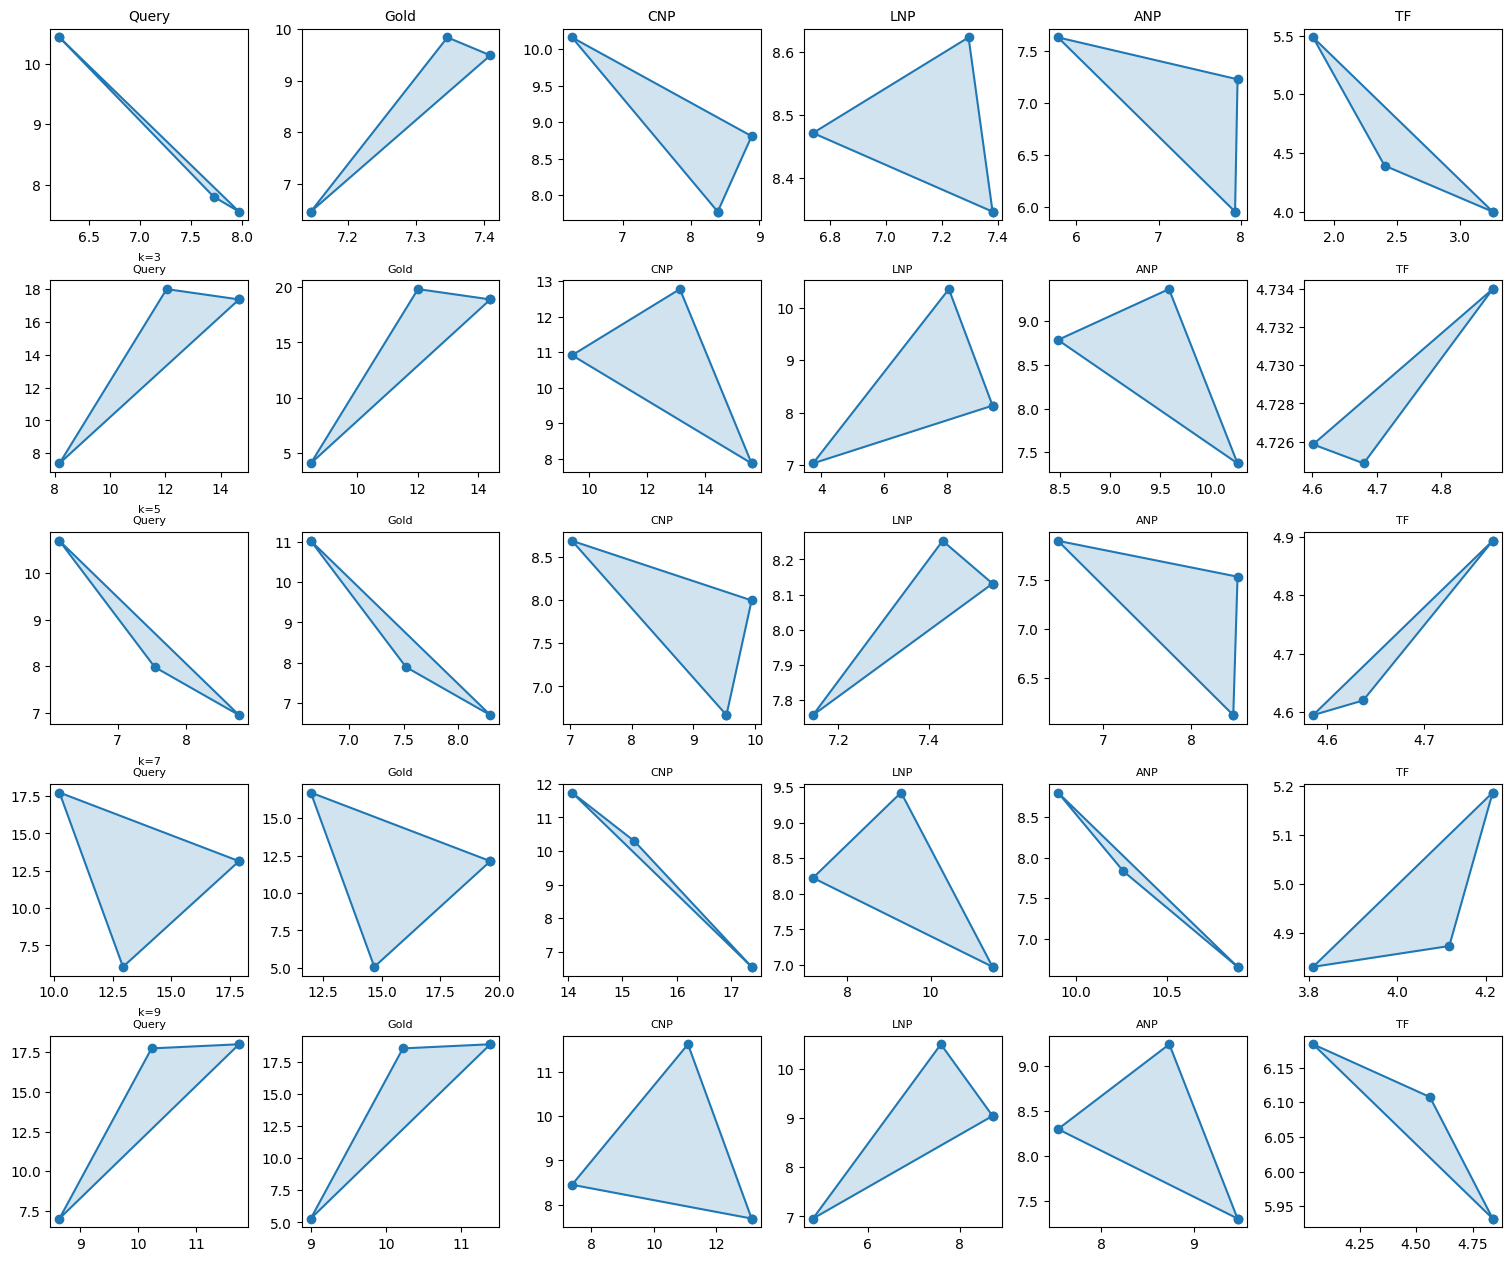

In [9]:
# list of models in the order you want columns
models = ['CNP','LNP','ANP','TF']
ncols = 2 + len(models)   # query + gold + one per model

context_sizes = [1,3,5,7,9]   # or whatever k you care about
side_count    = 3        # pick your polygon size

fig, axes = plt.subplots(
    nrows=len(context_sizes),
    ncols=ncols,
    figsize=(2.5 * ncols, 2.5 * len(context_sizes)),
    constrained_layout=True
)

for i, k in enumerate(context_sizes):
    # 1) Sample one example at context size k
    reader = PolygonSentenceReader(
        batch_size=1,
        max_num_context=context_sizes[-1],
        max_seq_len=x_size,
        min_num_sides=side_count,
        max_num_sides=side_count,
        center=(12,12),
        radius=6,
        testing=True,
    )

    ctx_x, ctx_y, tgt_x, tgt_y, _, true_poly, true_transformed_poly, *_ = (
        reader.generate_polygon_batch_few_shot_transformation_task(
            num_context=k,
            transformation_type=None
        )
    )

    ctx_x = ctx_x.to(device)
    ctx_y = ctx_y.to(device)
    tgt_x = tgt_x.to(device)
    tgt_y = tgt_y.to(device)

    # decode ground‐truth
    query_vertices = true_poly[0][0].vertices
    query_tokenised = true_poly[0][0].to_tokenised()
    gold_vertices  = true_transformed_poly[0][0].vertices

    # plot query and gold
    plot_polygon_on_ax(axes[i,0], query_vertices, title=f"k={k}\nQuery")
    plot_polygon_on_ax(axes[i,1], gold_vertices,  title="Gold")

    # 2) get each model’s prediction for this same example
    for j, model_name in enumerate(models):
        model = {'CNP':cnp_model, 'LNP':np_model,
                 'ANP':anp_model,'TF':tf_model}[model_name]
        # your routine to get a single predicted token sequence
        if model_name == 'TF':
            B, C, _ = ctx_x.shape
            for x in range(B):
              # Build prompt
              prompt = []
              for y in range(C):
                  toks = ctx_x[x,y].tolist()
                  while toks and toks[-1]==0.0: toks.pop()
                  prompt += toks
                  toks = ctx_y[x,y].tolist()
                  while toks and toks[-1]==0.0: toks.pop()
                  prompt += toks
                  prompt.append(EOS_TOKEN)

              partial = tgt_x[x,0].tolist()
              while partial and partial[-1]==0.0: partial.pop()
              prompt += partial
              L_tgt = len(partial)

              # Autoregressive loop
              generated = prompt.copy()
              for _ in range(L_tgt):
                  if len(generated) > 512:
                      generated = generated[-512:]
                  inp = (
                      torch.tensor(generated, device=device)
                          .unsqueeze(1).unsqueeze(-1)
                  )  # [seq_len, 1, 1]
                  logits = model(inp)    # → same shape
                  nxt = logits[-1, 0, 0].item()
                  generated.append(nxt)

              # Extract the newly generated segment
              pred_y = generated[-L_tgt:] # length tgt_y_len
        else:
            p_y_dist, *_ = model(
                ctx_x, ctx_y, tgt_x, None
            )
            pred_y = p_y_dist.mean.mean(0)[0, -1].tolist()
        pred_polygon = Polygon.from_tokenised(pred_y[:len(query_tokenised)], query_tokenised[0])
        pred_vertices = pred_polygon.vertices

        # plot into column 2+j
        ax = axes[i, 2+j]
        plot_polygon_on_ax(ax, pred_vertices, title=model_name)

# label the top of each column
col_titles = ["Query","Gold"] + models
for j, t in enumerate(col_titles):
    axes[0, j].set_title(t, fontsize=10)

plt.show()